## import

In [1]:
import matplotlib.pyplot as plt
from cycler import cycler
import pandas as pd
from matplotlib.ticker import MultipleLocator, FuncFormatter


In [2]:
# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

## plot pressure gauge data

In [5]:
from pathlib import Path

# file_path = Path.cwd() / "1" / "1.xlsx"  # 获取当前工作目录的目录下的 "1/1.xlsx" 文件路径
# file_path = Path.cwd().parent / "1" / "1.xlsx" # 获取当前工作目录的父目录下的 "1/1.xlsx" 文件路径


example_path = Path.cwd() / "model" / "Zgabay_Evo5.xlsx"
try:
    xls = pd.ExcelFile(example_path, engine="openpyxl")
    print("Sheets:", xls.sheet_names)
except FileNotFoundError:
    print(f"找不到文件: {example_path}")
except Exception as e:
    print("读取 Excel 时出错:", e)

Sheets: ['Information', 'Signal Summary', 'Grid', 'pressure_drop', 'pressure_drop (2)']


In [6]:
# 读取指定 sheet（'pressure_drop (2)'），打印标题和列名，并将每列数据导出为 notebook 变量（变量名由列名简化而来）
sheet_name = "pressure_drop (2)"

try:
    # 读取为带列名的 DataFrame
    sheet_df = xls.parse(sheet_name)
except Exception as e:
    raise RuntimeError(f"无法读取 sheet '{sheet_name}': {e}")

# 尝试从最上方单元格判断是否存在显式的标题（例如表格上方有单独的一行标题）
_rows = xls.parse(sheet_name, header=None)
top_cell = _rows.iloc[0, 0] if not _rows.empty else None
if isinstance(top_cell, str) and top_cell.strip() and top_cell.strip() not in list(sheet_df.columns):
    sheet_title = top_cell.strip()
else:
    sheet_title = sheet_name

print("Sheet title:", sheet_title)
print("Columns:", list(sheet_df.columns))

# 将每一列导出为变量，变量名由列名规范化得到（非字母数字替换为下划线，若以数字开头则加前缀下划线）
created_vars = {}
for col in sheet_df.columns:
    # 跳过完全空的列名
    if col is None:
        continue
    name = str(col).strip()
    if not name:
        continue
    # 规范化为合法的 Python 标识符
    var_name = ''.join(ch if (ch.isalnum() or ch == "_") else "_" for ch in name)
    if var_name and var_name[0].isdigit():
        var_name = "_" + var_name
    if not var_name:
        var_name = "col"
    base = var_name
    i = 1
    # 避免覆盖已有全局变量
    while var_name in globals():
        var_name = f"{base}_{i}"
        i += 1
    # 将该列作为 pandas Series 赋值到全局命名空间
    globals()[var_name] = sheet_df[col]
    created_vars[var_name] = col

print(f"Created {len(created_vars)} variables from sheet '{sheet_name}':")
for vn, col in created_vars.items():
    print(f"  {vn}  <- column '{col}' (length={len(globals()[vn])})")

# 显示前几行作为校验
print("\nPreview (first 5 rows) of the dataframe:")
print(sheet_df.head())

Sheet title: pressure_drop (2)
Columns: ['Date-Time', 13004, 13713, 14851, 15321, 16598, 17423, 'delta_time']
Created 8 variables from sheet 'pressure_drop (2)':
  Date_Time  <- column 'Date-Time' (length=52988)
  _13004  <- column '13004' (length=52988)
  _13713  <- column '13713' (length=52988)
  _14851  <- column '14851' (length=52988)
  _15321  <- column '15321' (length=52988)
  _16598  <- column '16598' (length=52988)
  _17423  <- column '17423' (length=52988)
  delta_time  <- column 'delta_time' (length=52988)

Preview (first 5 rows) of the dataframe:
            Date-Time     13004    13713     14851     15321     16598  \
0 2022-03-15 09:00:00  0.000000  0.00000  0.000000  0.000000  0.000000   
1 2022-03-15 09:00:10  0.787000 -0.00218  0.000000  0.000000 -0.007625   
2 2022-03-15 09:00:20  0.787000 -0.00218  0.012052  0.067000 -0.012000   
3 2022-03-15 09:00:30  1.058329  0.00482  0.019000  0.067000 -0.012000   
4 2022-03-15 09:00:40  1.216000  0.00482  0.006966  0.127169 -0.00

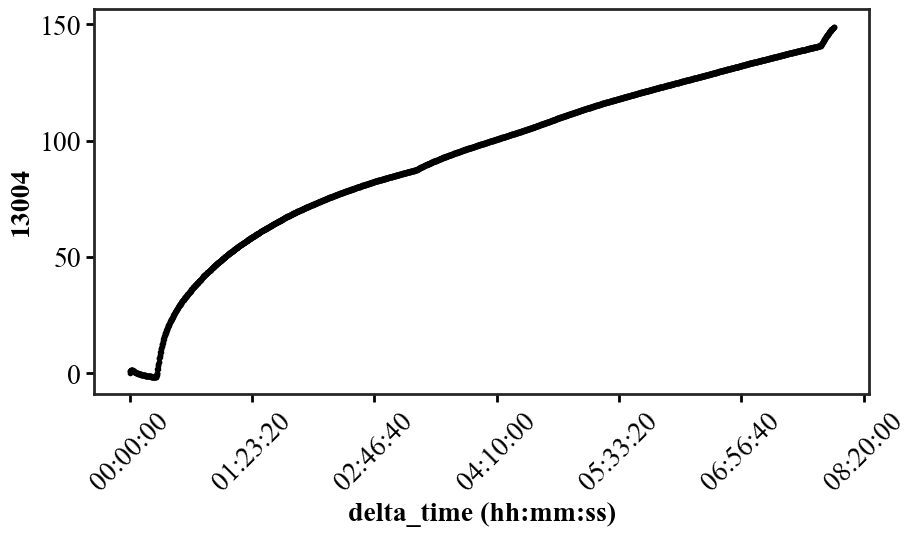

In [7]:
from matplotlib.ticker import FuncFormatter

# 过滤出 Date-Time 在 2022-03-15 09:00:00 起 8 小时内的数据，并以 delta_time 为 x 轴（显示为 hh:mm:ss），13004 为 y 轴绘图
start = pd.Timestamp("2022-03-15 09:00:00")
end = start + pd.Timedelta(hours=8)

mask = (sheet_df["Date-Time"] >= start) & (sheet_df["Date-Time"] <= end)
df_plot = sheet_df.loc[mask].copy()

if df_plot.empty:
    print("指定时间范围内无数据。")
else:
    # 使用 Date-Time - start 作为 x（Timedelta），并把 x 转为秒用于绘图，x 轴标签显示为 hh:mm:ss
    x_td = df_plot["Date-Time"] - start
    x_sec = x_td.dt.total_seconds()
    y = df_plot[13004]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_sec, y, marker=".", linestyle="-")
    ax.set_xlabel("delta_time (hh:mm:ss)")
    ax.set_ylabel("13004")

    def _sec_to_hms(x, pos=None):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"
    ax.xaxis.set_major_formatter(FuncFormatter(_sec_to_hms))

    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

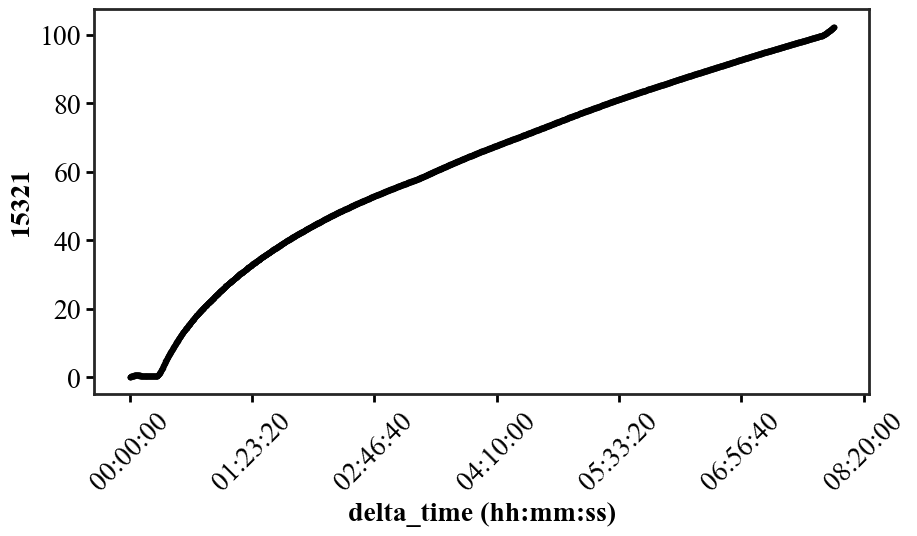

In [8]:
# 以 delta_time 为 x（显示为 hh:mm:ss），15321 为 y 绘图（时间范围已在 df_plot 中筛选）
if df_plot.empty:
    print("指定时间范围内无数据。")
else:
    # 优先复用已计算的 x_sec；若不存在则由 delta_time 解析得到秒数
    x = x_sec if "x_sec" in globals() else pd.to_timedelta(df_plot["delta_time"].astype(str)).dt.total_seconds()
    y_15321 = df_plot[15321]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, y_15321, marker=".", linestyle="-")
    ax.set_xlabel("delta_time (hh:mm:ss)")
    ax.set_ylabel("15321")
    # ax.set_title("delta_time ~ 15321 (2022-03-15 09:00:00 起 8 小时)")

    # 复用已有的格式化函数；若不存在则定义一个
    try:
        fmt = FuncFormatter(_sec_to_hms)
    except NameError:
        def _sec_to_hms(val, pos=None):
            h = int(val // 3600)
            m = int((val % 3600) // 60)
            s = int(val % 60)
            return f"{h:02d}:{m:02d}:{s:02d}"
        fmt = FuncFormatter(_sec_to_hms)

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

## curves fitting (fitting perm and delta p together)

### pressure fitting

Best-fit k   = 4.965e+01 mD
Best-fit A   = 165.510 psi   (≈ p0 - p1)
Best-fit eta = 3.378e+00 ft^2/s
R^2          = 0.9838


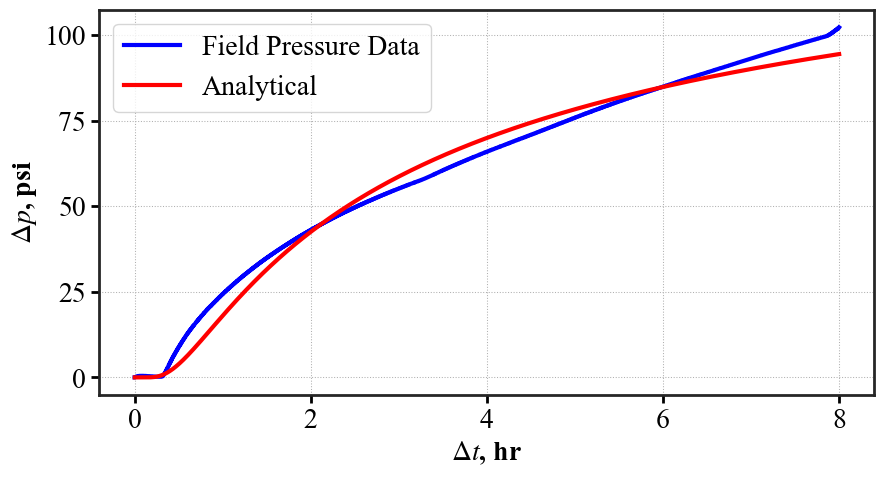

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- erfc ----------
try:
    from numpy import erfc as _erfc
except Exception:
    import math
    _erfc = np.vectorize(lambda z: 1.0 - math.erf(z))

# ---------- 单位换算与模型 ----------
def diffusivity_ft2_per_s(k_mD, mu_cP, phi, ct_per_psi):
    """k[mD], mu[cP], phi[-], ct[1/psi]  -> η[ft^2/s]"""
    return ((9.869233e-16)/(1e-3)*6894.757*3.2808**2) * k_mD / (mu_cP * phi * ct_per_psi)

def f_kernel(t_sec, k_mD, x_ft, mu_cP, phi, ct_per_psi):
    """f_k(t) = erfc( x / (2*sqrt(η t)) )"""
    t = np.asarray(t_sec, float)
    t = np.clip(t, 1e-9, None)
    eta = diffusivity_ft2_per_s(k_mD, mu_cP, phi, ct_per_psi)
    z = x_ft / (2.0*np.sqrt(eta*t))
    return _erfc(z)

def A_opt_given_k(t_sec, y_psi, k_mD, x_ft, mu_cP, phi, ct_per_psi, nonneg=True):
    """对给定 k 的最优 A（最小二乘解析解），可选非负约束"""
    f = f_kernel(t_sec, k_mD, x_ft, mu_cP, phi, ct_per_psi)
    num = np.nansum(f*y_psi)
    den = np.nansum(f*f)
    if den <= 0:
        return 0.0
    A = num/den
    if nonneg:
        A = max(0.0, A)
    return float(A)

def sse_of_k_log10(logk, t_sec, y_psi, x_ft, mu_cP, phi, ct_per_psi):
    k = 10.0**logk
    A = A_opt_given_k(t_sec, y_psi, k, x_ft, mu_cP, phi, ct_per_psi, nonneg=True)
    yhat = A * f_kernel(t_sec, k, x_ft, mu_cP, phi, ct_per_psi)
    r = y_psi - yhat
    return np.nansum(r*r)

def fit_A_k_dual(t_sec, y_psi, x_ft, mu_cP, phi, ct_per_psi,
                 k_bounds=(1e-6, 10.0), return_curve=True):
    """
    同时拟合 A=(p0-p1) 与 k（mD）。
    方法：在 log10(k) 上黄金分割搜索，A 用解析解。
    """
    t = np.asarray(t_sec, float)
    y = np.asarray(y_psi, float)
    m = np.isfinite(t)&np.isfinite(y)&(t>0)
    t, y = t[m], y[m]
    if t.size < 5:
        raise ValueError("有效数据点不足")

    # 先粗网格确定区间
    lo, hi = np.log10(k_bounds[0]), np.log10(k_bounds[1])
    grid = np.linspace(lo, hi, 200)
    sse_vals = np.array([sse_of_k_log10(g, t, y, x_ft, mu_cP, phi, ct_per_psi) for g in grid])
    j = int(np.argmin(sse_vals))
    a = grid[max(0, j-1)]
    b = grid[min(len(grid)-1, j+1)]
    if j == 0: a, b = lo, grid[3]
    if j == len(grid)-1: a, b = grid[-4], hi

    # 黄金分割
    phi_g = (1 + np.sqrt(5)) / 2
    invphi = 1/phi_g
    c = b - invphi*(b-a)
    d = a + invphi*(b-a)
    fc = sse_of_k_log10(c, t, y, x_ft, mu_cP, phi, ct_per_psi)
    fd = sse_of_k_log10(d, t, y, x_ft, mu_cP, phi, ct_per_psi)
    for _ in range(80):
        if (b - a) < 1e-6:
            break
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a)
            fc = sse_of_k_log10(c, t, y, x_ft, mu_cP, phi, ct_per_psi)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a)
            fd = sse_of_k_log10(d, t, y, x_ft, mu_cP, phi, ct_per_psi)

    logk_best = (a+b)/2.0
    k_best = 10.0**logk_best
    A_best = A_opt_given_k(t, y, k_best, x_ft, mu_cP, phi, ct_per_psi, nonneg=True)
    yhat = A_best * f_kernel(t, k_best, x_ft, mu_cP, phi, ct_per_psi)

    ss_res = np.nansum((y - yhat)**2)
    ss_tot = np.nansum((y - np.nanmean(y))**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    if return_curve:
        return k_best, A_best, R2, (t, yhat)
    else:
        return k_best, A_best, R2

# ===================== 使用示例（与你的数据衔接） =====================
GAUGE_COL = 15321#13004
t_sec = (df_plot["Date-Time"] - df_plot["Date-Time"].iloc[0]).dt.total_seconds().to_numpy()
y_psi = df_plot[GAUGE_COL].to_numpy()

# —— 在这里填入物性与几何（单位务必与注释一致）——

x_ft       = 250       # 计量点到边界/裂缝面的法向距离 [ft]
mu_cP      = 0.185        # 黏度 [cP]
phi        = 0.3       # 孔隙度 [-]
ct_per_psi = 1.94e-5     # 体积压缩系数 [1/psi]



# 拟合（按需要可放宽 k 范围）
k_best_mD, A_best_psi, R2, (t_used, yhat) = fit_A_k_dual(
    t_sec, y_psi, x_ft, mu_cP, phi, ct_per_psi,
    k_bounds=(40, 80.0), return_curve=True
)

eta_best = diffusivity_ft2_per_s(k_best_mD, mu_cP, phi, ct_per_psi)
print(f"Best-fit k   = {k_best_mD:.3e} mD")
print(f"Best-fit A   = {A_best_psi:.3f} psi   (≈ p0 - p1)")
print(f"Best-fit eta = {eta_best:.3e} ft^2/s")
print(f"R^2          = {R2:.4f}")

# 叠加绘图
def _sec_to_hms(x, pos=None):
    h = int(x // 3600); m = int((x % 3600)//60); s = int(x % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t_sec, y_psi, color='blue', lw = 3, label='Field Pressure Data')
ax.plot(t_used, yhat, color='red', lw = 3, label='Analytical')
ax.xaxis.set_major_formatter(FuncFormatter(_sec_to_hms))
ax.set_xticks([0, 7200,  14400,  21600, 28800])
ax.set_xticklabels(['0','2','4','6','8'])
ax.yaxis.set_major_locator(MultipleLocator(25))     # 每 2000 ft 一个大刻度


ax.set_xlabel(r'$\Delta t$, hr')
ax.set_ylabel(r'$\Delta p$, psi')
ax.grid(True, which='both', linestyle=':', linewidth=0.75)
ax.legend()

plt.savefig("pressure_strain_matching_gauge4.png", dpi=600,bbox_inches='tight')

plt.show()
# fig.show()


### strain change fitting

In [51]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd

from merge_h5_files import merge_preserve_time
import os
import glob

In [52]:
# Read h5 files
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
print(list(f1.keys()))
# 继续进入下一层
data_group = f1['data']
print(data_group)
# print(list(data_group.keys()))
# 继续进入下一层
# data_group2 = data_group['Raw[0]']
# print(list(data_group2.keys()))
# 继续进入下一层
# RawData = data_group2['RawData']
# print(RawData)
# RawDataTime = data_group2['RawDataTime']
# print(RawDataTime)

['data', 'depth', 'stamps', 'stamps_unix']
<HDF5 dataset "data": shape (7008, 57218), type "<f4">


In [53]:
from slippage_clbrt_shift import shift_depth_piecewise, invert_shift_depth_piecewise

gauges = np.array([13004, 15321, 13753.1])
gauge_to_fiber = invert_shift_depth_piecewise(gauges, z0=12000.0, z1=16000.0, s0=145.0, s1=160.0)
print("测点深度 gauges: ", gauges)
print("对应纤维深度 gauge_to_fiber: ", gauge_to_fiber)

测点深度 gauges:  [13004.  15321.  13753.1]
对应纤维深度 gauge_to_fiber:  [12855.79078456 15164.13449564 13602.09215442]


In [54]:
from tomlkit import date


dstrain = (f1['data'])  #（time, depth）
depth = (f1['depth'])
date_str = (f1['stamps'])
date_utc = (f1['stamps_unix'])


depth = np.asarray(depth)
dstrain = np.asarray(dstrain)
date_str = np.asarray(date_str)
date_utc = np.asarray(date_utc)

In [55]:
def nearest_col_indices(depth_1d, targets):
    """
    targets 可以是标量或数组。返回与每个 target 最近的列索引。
    """
    t = np.atleast_1d(targets).astype(float)
    # 计算 |depth - target| 并在列轴上取最小
    idx = np.argmin(np.abs(depth_1d[None, :] - t[:, None]), axis=1)
    return idx

targets = [gauge_to_fiber[0], gauge_to_fiber[1]]
idx = nearest_col_indices(depth, targets)
depth_near = depth[idx]
err = targets - depth_near

print("targets:    ", targets)
print("idx:        ", idx)
print("depth_near: ", depth_near)
print("error(ft):  ", err)


targets:     [12855.790784557908, 15164.134495641347]
idx:         [38986 45986]
depth_near:  [12855.825 15164.092]
error(ft):   [-0.03441075  0.04269877]


In [56]:
cols = dstrain[:, idx[0]-42]                 # shape = (N_time, len(targets)) 
cols*=-1
# cols = dstrain[:, idx [1]-86]                 # shape = (N_time, len(targets)) 
# cols*=-1

length = len(cols)
print(f"读取 {length} 条记录")
print("cols", cols)

读取 7008 条记录
cols [0.        0.        0.        ... 6.4721313 6.4721313 6.4721313]


In [57]:
#  你的字符串列是 bytes，需要先解码成 str 再解析为 datetime（naive）
ds = pd.to_datetime(pd.Series(date_str.astype(str)), format='%m/%d/%Y %H:%M:%S.%f')
# print(type(ds))
# print(ds)

#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2022-03-15 09:00:00")
end   = pd.Timestamp("2022-03-15 17:00:00")

mask = (ds >= start) & (ds <= end)
# mask = np.ones(len(ds), dtype=bool)

t_sel    = ds[mask]
print(mask)
# print(t_sel)


0       False
1       False
2       False
3       False
4       False
        ...  
7003    False
7004    False
7005    False
7006    False
7007    False
Length: 7008, dtype: bool


In [ ]:
#完整输入mask

# 打印 mask 在 ds 中为 True 的位置索引（按位置编号）
# import numpy as np
# idx_true = np.flatnonzero(mask.to_numpy())
# print(f"mask True indices count = {idx_true.size}")
# if idx_true.size <= 200:
#     print("indices:", idx_true.tolist())
# else:
#     print("indices (first 50):", idx_true[:50].tolist())
#     print("indices (last 50):", idx_true[-50:].tolist())

# 如需查看对应的时间戳：
# if idx_true.size <= 50:
#     print(ds.iloc[idx_true].to_string(index=True))

# === 找出 mask 从 False->True 与 True->False 的边界（支持多段） ===
# m = mask.to_numpy()
# n = m.size
# if n == 0:
#     print("mask is empty")
# else:
#     d = np.diff(m.astype(np.int8))
#     seg_starts = np.flatnonzero(d == 1) + 1  # False->True 的下一个位置
#     seg_ends   = np.flatnonzero(d == -1)     # True->False 的当前位置-1
#     if m[0]:
#         seg_starts = np.r_[0, seg_starts]
#     if m[-1]:
#         seg_ends = np.r_[seg_ends, n-1]
#     segments = list(zip(seg_starts, seg_ends))
#     print(f"True segments (inclusive index ranges, count={len(segments)}):")
#     for (s,e) in (segments[:5] if len(segments) > 0 else []):
#         print(f"  [{s}, {e}]  len={e - s + 1}    {ds.iloc[s]} -> {ds.iloc[e]}")
#     if len(segments) > 5:
#         print("  ...")
#     if segments:
#         s0, e0 = segments[0]
#         sL, eL = segments[-1]
#         print(f"First True block: start={s0}, end={e0}  ({ds.iloc[s0]} -> {ds.iloc[e0]})")
#         print(f"Last True block:  start={sL}, end={eL}  ({ds.iloc[sL]} -> {ds.iloc[eL]})")
    
#     # 可选：若 ds 是升序的，给出 searchsorted 估计边界
#     try:
#         i_left = int(ds.searchsorted(start, side='left'))
#         i_right = int(ds.searchsorted(end, side='right') - 1)
#         print(f"searchsorted bounds (assuming ds sorted): left={i_left}, right={i_right}")
#     except Exception:
#         pass


In [58]:
strian_sel    = cols[mask]
strian_sel = strian_sel - strian_sel[0]  # 以起始点为零点
# print(type(strian_sel))
# print(strian_sel)
print(len(strian_sel))

341


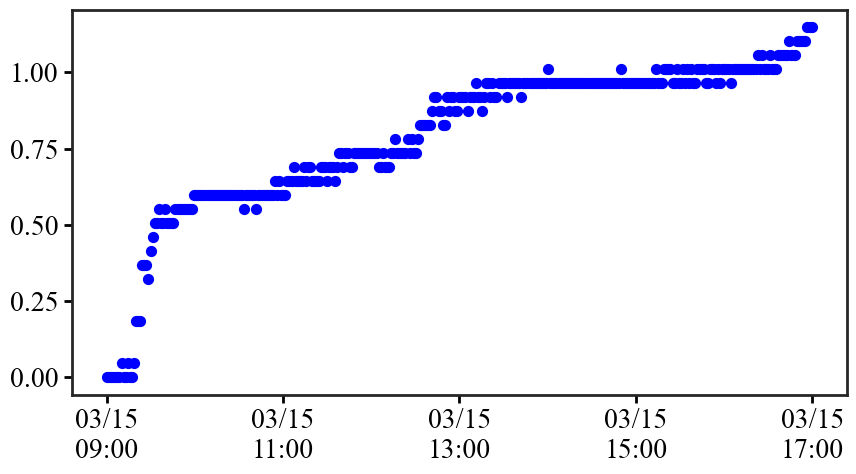

In [59]:
fig, ax = plt.subplots(figsize=(10,5))

#scatter plot
ax.scatter(t_sel, strian_sel, color='blue', s=50, label='Field Pressure Data')

ax.xaxis_date()
date_format = mdates.DateFormatter('%m/%d\n%H:%M')
ax.xaxis.set_major_formatter(date_format)
# 设置主刻度间隔为 1 小时
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# 给外侧轴留空间，避免被裁切
# fig.subplots_adjust(right=0.82)
plt.savefig('frac_curves_S6.png', dpi=600, bbox_inches='tight')
plt.show()



[strain-fit] k  = 1.625e+02 mD
[strain-fit] η  = 1.105e+01 ft^2/s
[strain-fit] A  = 1.34 με   (幅值 = α/E*(1-2ν)/(1-ν)*(p_i-p_1))
[strain-fit] R² = 0.9242


C:\Users\fengxiang.mao\AppData\Local\Temp\ipykernel_17768\2596614058.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['0','2','4','6','8'])


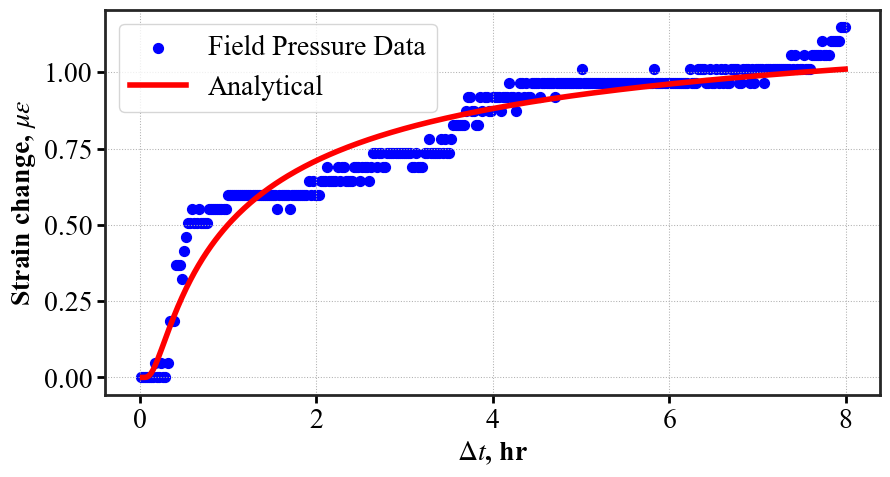

In [61]:
# ================== 只拟合 A 与 k 的简洁版（无 B、无 tau） ==================
from turtle import color
import numpy as np

# erfc 内核
try:
    from numpy import erfc as _erfc
except Exception:
    import math
    _erfc = np.vectorize(lambda z: 1.0 - math.erf(z))

# 单位换算：η[ft^2/s] = (0.0002637/86400) * k[mD] / (mu[cP] * phi * ct[1/psi])
def diffusivity_ft2_per_s(k_mD, mu_cP, phi, ct_per_psi):
    """k[mD], mu[cP], phi[-], ct[1/psi]  -> η[ft^2/s]"""
    return ((9.869233e-16)/(1e-3)*6894.757*3.2808**2) * k_mD / (mu_cP * phi * ct_per_psi)

# f_k(t) = erfc( dis / (2*sqrt(η*t)) )
def f_kernel(t_sec, k_mD, dis_ft, mu_cP, phi, ct_per_psi):
    t = np.asarray(t_sec, float)
    t = np.clip(t, 1e-9, None)  # 避免 t=0
    eta = diffusivity_ft2_per_s(k_mD, mu_cP, phi, ct_per_psi)
    z = dis_ft / (2.0 * np.sqrt(eta * t))
    return _erfc(z)

# 给定 k 的最优 A（解析最小二乘）
def A_opt_given_k(t_sec, y_vals, k_mD, dis_ft, mu_cP, phi, ct_per_psi, nonneg=True):
    f = f_kernel(t_sec, k_mD, dis_ft, mu_cP, phi, ct_per_psi)
    num = np.nansum(f * y_vals)
    den = np.nansum(f * f)
    if den <= 0:
        return 0.0
    A = num / den
    if nonneg:
        A = max(0.0, A)
    return float(A)

# SSE(log10 k)
def sse_of_logk(logk, t_sec, y_vals, dis_ft, mu_cP, phi, ct_per_psi):
    k = 10.0 ** logk
    A = A_opt_given_k(t_sec, y_vals, k, dis_ft, mu_cP, phi, ct_per_psi, nonneg=True)
    yhat = A * f_kernel(t_sec, k, dis_ft, mu_cP, phi, ct_per_psi)
    r = y_vals - yhat
    return float(np.nansum(r * r))

# 简单的一维黄金分割（log10 k 空间）
def golden_search_1d(fun, a, b, tol=1e-6, iters=80):
    phi = (1 + np.sqrt(5)) / 2
    invphi = 1 / phi
    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc, fd = fun(c), fun(d)
    for _ in range(iters):
        if (b - a) < tol:
            break
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a)
            fc = fun(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a)
            fd = fun(d)
    return (a + b) / 2.0

# 主拟合函数：只拟合 A（με）和 k（mD）
def fit_A_k_strain(t_sec, y_ueps, dis_ft, mu_cP, phi, ct_per_psi,
                   k_bounds=(1e-6, 1e3), return_curve=True):
    t = np.asarray(t_sec, float)
    y = np.asarray(y_ueps, float)
    m = np.isfinite(t) & np.isfinite(y) & (t > 0)
    t, y = t[m], y[m]
    if t.size < 5:
        raise ValueError("有效点太少，无法拟合。")

    # 粗网格锁区间
    lo, hi = np.log10(k_bounds[0]), np.log10(k_bounds[1])
    grid = np.linspace(lo, hi, 200)
    sse_vals = np.array([sse_of_logk(g, t, y, dis_ft, mu_cP, phi, ct_per_psi) for g in grid])
    j = int(np.argmin(sse_vals))
    a = grid[max(0, j-1)]
    b = grid[min(len(grid)-1, j+1)]
    if j == 0: a, b = lo, grid[3]
    if j == len(grid)-1: a, b = grid[-4], hi

    # 黄金分割精化
    logk_best = golden_search_1d(
        lambda lk: sse_of_logk(lk, t, y, dis_ft, mu_cP, phi, ct_per_psi), a, b,
        tol=1e-6, iters=80
    )
    k_best_mD = 10.0 ** logk_best
    A_best = A_opt_given_k(t, y, k_best_mD, dis_ft, mu_cP, phi, ct_per_psi, nonneg=True)
    yhat = A_best * f_kernel(t, k_best_mD, dis_ft, mu_cP, phi, ct_per_psi)

    # R^2
    ss_res = np.nansum((y - yhat)**2)
    ss_tot = np.nansum((y - np.nanmean(y))**2)
    R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    if return_curve:
        return k_best_mD, A_best, R2, (t, yhat)
    else:
        return k_best_mD, A_best, R2

# ================== 准备拟合所需 t(秒) 和 y(με) ==================
# 以可见窗口起点为 t=0
t0 = t_sel.iloc[0]
t_sec = (t_sel - t0).dt.total_seconds().to_numpy()
y_ueps = strian_sel.astype(float)  # 单位：με（microstrain）

# ================== 这里填写物性与几何（单位务必正确） ==================
dis_ft       = 250        # 纤维点到压力阶跃/裂缝面的法向距离 [ft]
mu_cP        = 0.185       # 黏度 [cP]
phi          = 0.30        # 孔隙度 [-]
ct_per_psi   = 1.94e-5     # 总压缩系数 [1/psi]

# ================== 执行拟合并叠加到现有散点图 ==================
k_best, A_best, R2, (t_used, yhat) = fit_A_k_strain(
    t_sec, y_ueps, dis_ft, mu_cP, phi, ct_per_psi,
    k_bounds=(1e-6, 1e3), return_curve=True
)
eta_best = diffusivity_ft2_per_s(k_best, mu_cP, phi, ct_per_psi)

print(f"[strain-fit] k  = {k_best:.3e} mD")
print(f"[strain-fit] η  = {eta_best:.3e} ft^2/s")
print(f"[strain-fit] A  = {A_best:.2f} με   (幅值 = α/E*(1-2ν)/(1-ν)*(p_i-p_1))")
print(f"[strain-fit] R² = {R2:.4f}")

# 叠加绘图
def _sec_to_hms(x, pos=None):
    h = int(x // 3600); m = int((x % 3600)//60); s = int(x % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.scatter(t_sel, y_ueps, s=50, label='Field Pressure Data', color='blue')

t_used_dt = pd.to_datetime(t_used, unit='s', origin=t0)
ax2.plot(t_used_dt, yhat, lw=4, color='red',
         label='Analytical')
        #  label=f"fit: k={k_best:.2e} mD, A={A_best:.1f} με, R²={R2:.3f}")

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# ax2.xaxis.set_major_formatter(FuncFormatter(_sec_to_hms))
# ax2.set_xticks([0, 7200,  14400,  21600, 28800])
ax2.set_xticklabels(['0','2','4','6','8'])
ax2.set_xlabel(r'$\Delta t$, hr')
ax2.set_ylabel(r"Strain change, $\mu\varepsilon$")
ax2.legend()
ax2.grid(True, which='both', linestyle=':', linewidth=0.75)
# plt.tight_layout()
plt.show()


### loop to find the peak near the pressure gauge MD

In [ ]:

def nearest_col_indices(depth_1d, targets):
    """
    targets 可以是标量或数组。返回与每个 target 最近的列索引。
    """
    t = np.atleast_1d(targets).astype(float)
    # 计算 |depth - target| 并在列轴上取最小
    idx = np.argmin(np.abs(depth_1d[None, :] - t[:, None]), axis=1)
    return idx

targets = gauge_to_fiber[1]
idx = nearest_col_indices(depth, targets)
depth_near = depth[idx]
err = targets - depth_near

print("targets:    ", targets)
print("idx:        ", idx)
print("depth_near: ", depth_near)
print("error(ft):  ", err)

ds = pd.to_datetime(pd.Series(date_str.astype(str)), format='%m/%d/%Y %H:%M:%S.%f')
# print(type(ds))
# print(ds)

#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2022-03-15 09:00:00")
end   = pd.Timestamp("2022-03-15 17:00:00")

mask = (ds >= start) & (ds <= end)
# mask = np.ones(len(ds), dtype=bool)

t_sel    = ds[mask]
print(mask)

for i in range(0,100):
    # cols = dstrain[:, idx-42]                 # shape = (N_time, len(targets)) 
    # cols*=-1
    cols = dstrain[:, idx-i]                 # shape = (N_time, len(targets)) 
    cols*=-1
    # print("idx-i:", idx-i)
    # length = len(cols)
    # print(f"读取 {length} 条记录")
    # print("cols", cols)


    strian_sel    = cols[mask]
    strian_sel = strian_sel - strian_sel[0]  # 以起始点为零点
    fig, ax = plt.subplots(figsize=(10,5))

    #   scatter plot
    ax.scatter(t_sel, strian_sel, color='blue', s=50, label='Field Pressure Data')

    ax.xaxis_date()
    date_format = mdates.DateFormatter('%m/%d\n%H:%M')
    ax.xaxis.set_major_formatter(date_format)
    # 设置主刻度间隔为 1 小时
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    #图例显示index
    ax.set_title(f'Fiber Index: {idx-i}')

